<a href="https://colab.research.google.com/github/psaw/hse-ai24-ml/blob/main/Chocolate_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline-решение

## Импорт библиотек, загрузка данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

In [3]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [4]:
train_df = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [5]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


Удаляем все строки с пропусками

In [6]:
train_df.dropna(axis=0, inplace=True)

Выделяем матрицу объект-признак и вектор с целевой переменной

In [7]:
X = train_df # .drop('Rating', axis=1)
y = train_df['Rating']

## Преобразование данных

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1253 non-null   object 
 1   Specific Bean Origin  1253 non-null   object 
 2   REF                   1253 non-null   int64  
 3   Review                1253 non-null   int64  
 4   Cocoa Percent         1253 non-null   object 
 5   Company Location      1253 non-null   object 
 6   Rating                1253 non-null   float64
 7   Bean Type             1253 non-null   object 
 8   Broad Bean Origin     1253 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 97.9+ KB


In [9]:
def cocoa_percent_transformer(X):
    X['Cocoa Percent_numeric'] = X['Cocoa Percent'].str.rstrip('%').astype(float)
    return X


def split_and_replace(X, column_name, separator, replace_value):
    X[column_name+'_cat'] = X[column_name].str.split(separator, expand=True)[0].replace(replace_value, np.nan)
    return X


def clean_df(df):
    _df = cocoa_percent_transformer(df)
    print("1: ", _df.shape)
    _df = split_and_replace(_df, 'Broad Bean Origin', ',', '\xa0')
    print("2: ", _df.shape)
    _df = split_and_replace(_df, 'Specific Bean Origin', ',', '\xa0')
    print("3: ", _df.shape)
    _df = split_and_replace(_df, 'Bean Type', r'[ ,(]', '\xa0')
    print("4: ", _df.shape)
    # Объединение с оригинальными данными, за исключением удаляемых столбцов
    _df = _df.drop(['REF', 'Cocoa Percent', 'Bean Type', 'Broad Bean Origin', 'Specific Bean Origin'], axis=1)
    print("5: ", _df.shape)
    return _df

print("in: ", X.shape)
X_new = clean_df(X.copy())
print("out: ", X_new.shape)
X_new

in:  (1253, 9)
1:  (1253, 10)
2:  (1253, 11)
3:  (1253, 12)
4:  (1253, 13)
5:  (1253, 8)
out:  (1253, 8)


,Company,Review,Company Location,Rating,Cocoa Percent_numeric,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
0,Willie's Cacao,2009,U.K.,3.25,72.0,Venezuela,Rio Caribe,Trinitario
1,Beschle (Felchlin),2010,Switzerland,3.50,72.0,Venezuela,Ocumare,NaN
2,Dark Forest,2015,U.S.A.,3.00,70.0,Tanzania,Tanzania,NaN
3,Brasstown aka It's Chocolate,2013,U.S.A.,3.00,72.0,Dominican Republic,Cooproagro,Trinitario
4,Pralus,2006,France,3.50,75.0,Indonesia,Java,Criollo
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,2009,U.K.,3.00,80.0,Madagascar,Madagascar,Criollo
1251,Marana,2016,Peru,2.75,70.0,Peru,Cusco,NaN
1252,Arete,2015,U.S.A.,3.50,68.0,Peru,Nacional,Forastero
1253,Fresco,2011,U.S.A.,3.50,72.0,Dominican Republic,Conacado,NaN


#### Биннирование признака `Cocoa Percent_numeric`

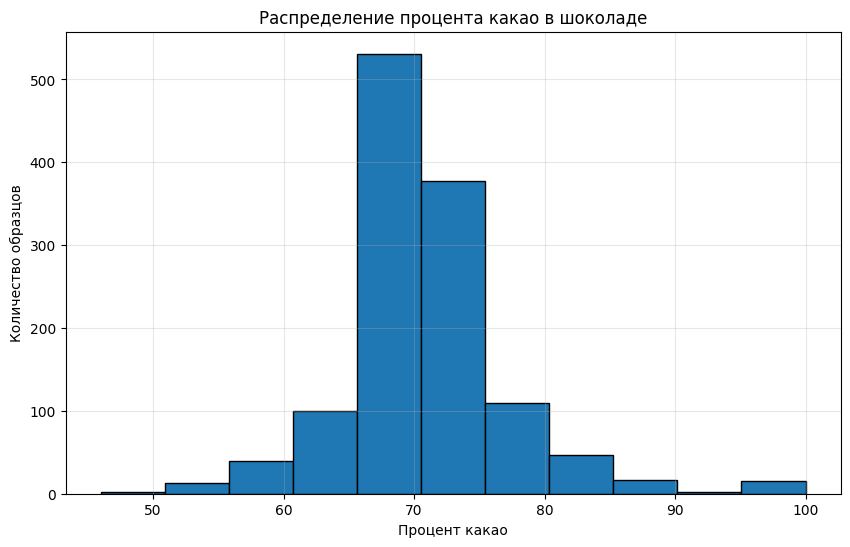

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(X_new['Cocoa Percent_numeric'], bins=11, edgecolor='black')
plt.title('Распределение процента какао в шоколаде')
plt.xlabel('Процент какао')
plt.ylabel('Количество образцов')
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='kmeans', random_state=42)
discretizer.fit(X_new[['Cocoa Percent_numeric']])
X_new['Cocoa Percent_numeric_binned'] = discretizer.transform(X_new[['Cocoa Percent_numeric']])


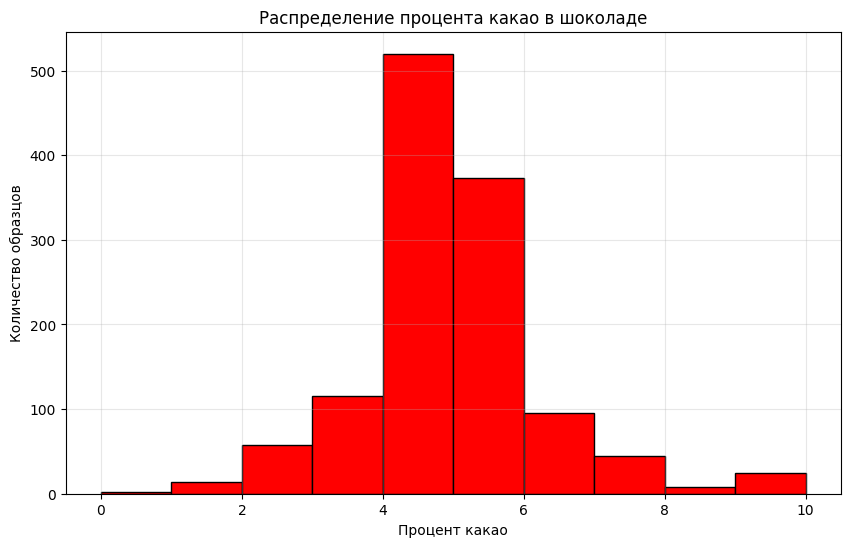

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(X_new['Cocoa Percent_numeric_binned'], color='red', edgecolor='black')
plt.title('Распределение процента какао в шоколаде')
plt.xlabel('Процент какао')
plt.ylabel('Количество образцов')
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
X_new['Cocoa Percent_numeric_binned'].value_counts()

Cocoa Percent_numeric_binned
4.0     520
5.0     373
3.0     115
6.0      95
2.0      57
7.0      44
10.0     15
1.0      14
9.0      10
8.0       8
0.0       2
Name: count, dtype: int64

#### Корреляция признаков

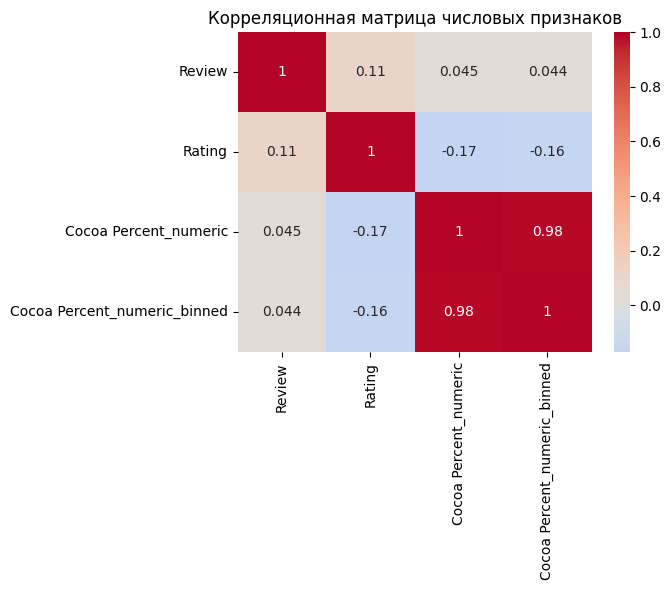

In [14]:
plt.figure(figsize=(7, 6))
correlation_matrix = X_new.select_dtypes(include=['float64', 'int64']).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()


Ничего интересного.  
Признак `Cocoa Percent_numeric` удалим позже. 

In [15]:
X_new.describe(include='object')

,Company,Company Location,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
count,1253,1253,1198,1253,625
unique,376,58,66,529,9
top,Soma,U.S.A.,Venezuela,Madagascar,Trinitario
freq,34,520,148,46,293


In [16]:
import association_metrics as am
warnings.filterwarnings('ignore')

XC = X_new.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

,Company,Company Location,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
Company,1.000000,0.999651,0.633931,0.653217,0.816914
Company Location,0.999651,1.000000,0.378944,0.735872,0.268613
Broad Bean Origin_cat,0.633931,0.378944,1.000000,0.976352,0.506266
Specific Bean Origin_cat,0.653217,0.735872,0.976352,1.000000,0.871187
Bean Type_cat,0.816914,0.268613,0.506266,0.871187,1.000000


`Broad Bean Origin_cat` и `Specific Bean Origin_cat` сильно связаны.  
Удалим `Broad Bean Origin_cat`, т.к. в нем есть пропуски

In [17]:
X_new.drop('Broad Bean Origin_cat', axis=1, inplace=True)

#### Визуализируем зависимость целевой переменной от категориальных
(перебрал все категории, ничего не увидел)

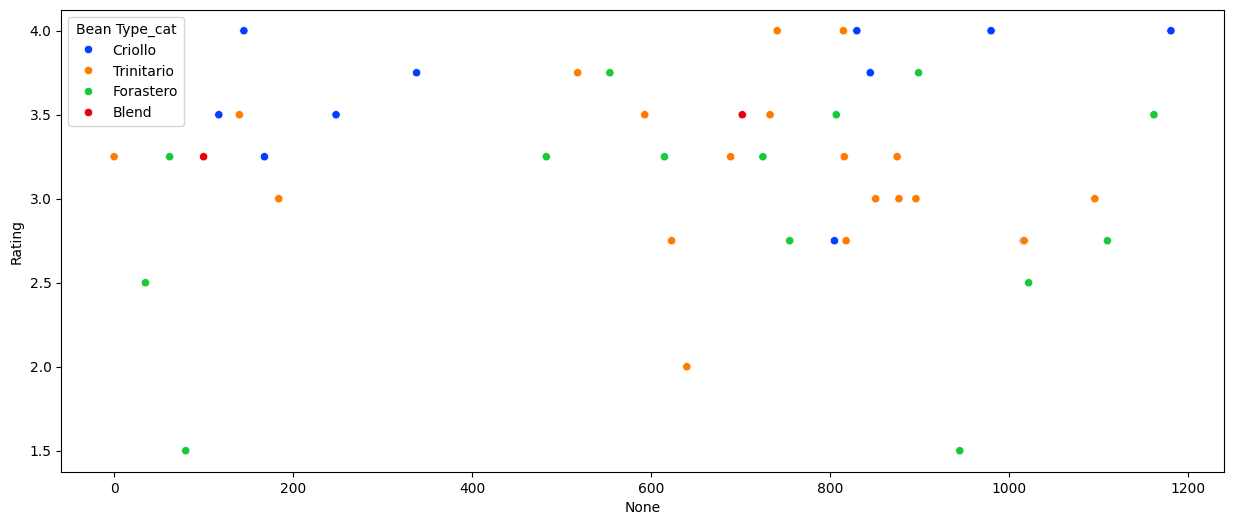

In [18]:
plt.figure(figsize=(15, 6))
XX=X_new.sample(100)
sns.scatterplot(data=XX, x=XX.index, y=y[XX.index], hue='Bean Type_cat', palette='bright');

#### Распределение целевой переменной

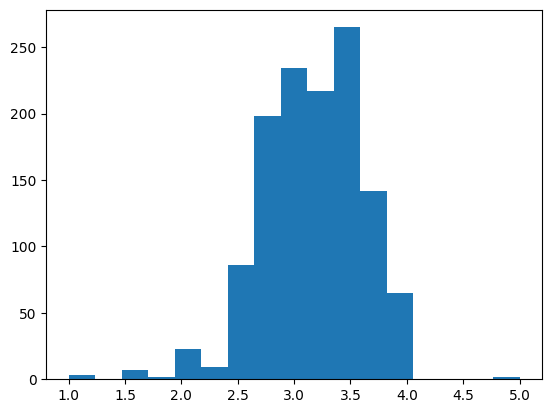

In [19]:
plt.hist(y, bins=17);

Близко к нормальному распределению. Ничего с этим делать не будем.

#### Обработка категориальных признаков

In [20]:
cat_cols = X_new.columns[X_new.dtypes == 'object']
num_cols = X_new.columns[X_new.dtypes != 'object']

Review


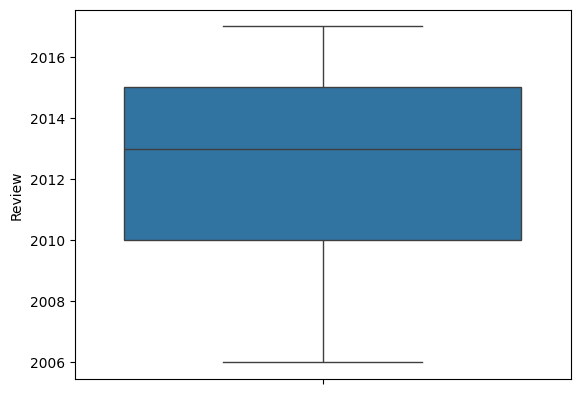

Rating


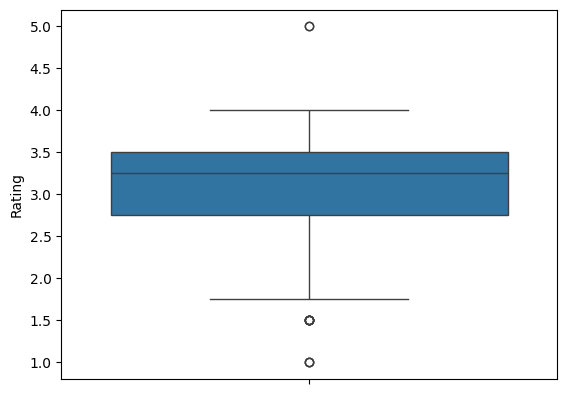

Cocoa Percent_numeric


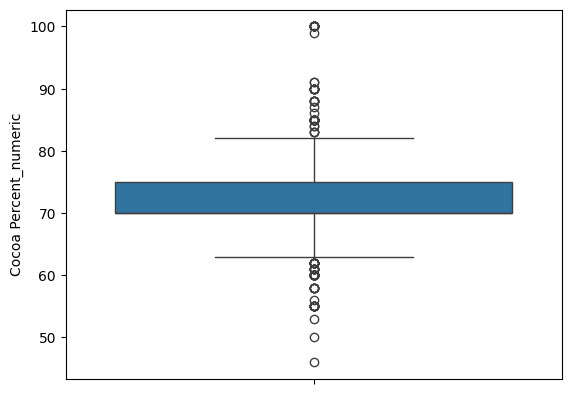

Cocoa Percent_numeric_binned


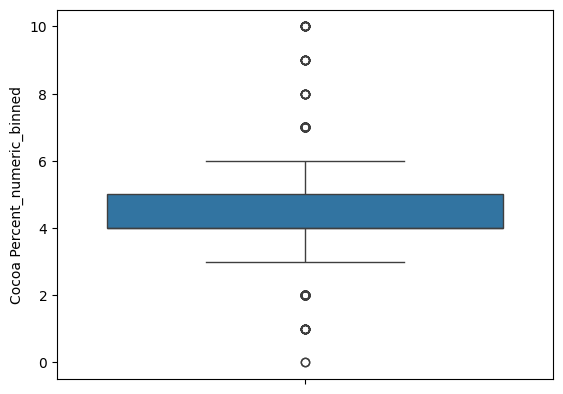

In [21]:
for col in num_cols:
    print(col)
    sns.boxplot(X_new[col])
    plt.show()

Даже экстремальные значения "процент какао" встречаются в жизни, поэтому оставляем как есть.

## Заполнение пропусков

In [22]:
X_new.isna().sum()

Company                           0
Review                            0
Company Location                  0
Rating                            0
Cocoa Percent_numeric             0
Specific Bean Origin_cat          0
Bean Type_cat                   628
Cocoa Percent_numeric_binned      0
dtype: int64

Заполнение пропусков в `Bean Type_cat`:
1. где возможно, заполнять модой по группировке по `Specific Bean Origin_cat`
2. остальное - значением `unknown`

In [23]:
# X_train_transformed['Bean Type_cat'] = X_train_transformed.groupby(['Broad Bean Origin_cat', 'Specific Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

# X_new['Bean Type_cat'] = X_new.groupby(['Broad Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

X_new['Bean Type_cat'] = X_new.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_new['Bean Type_cat'] = X_new['Bean Type_cat'].fillna('unknown')

In [24]:
X_new.isna().sum()

Company                         0
Review                          0
Company Location                0
Rating                          0
Cocoa Percent_numeric           0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

## Обучение модели

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [25]:
X_new.drop(['Rating', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [26]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       1253 non-null   object 
 1   Review                        1253 non-null   int64  
 2   Company Location              1253 non-null   object 
 3   Specific Bean Origin_cat      1253 non-null   object 
 4   Bean Type_cat                 1253 non-null   object 
 5   Cocoa Percent_numeric_binned  1253 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 100.8+ KB


Обучаем CatBoostRegressor с гиперпараметрами по умолчанию на всех данных

In [27]:
from catboost import CatBoostRegressor
cat_features = [0, 2, 3, 4]
model = CatBoostRegressor(cat_features=cat_features, verbose=False)

In [28]:
model.fit(X_new, y)

In [29]:
model.score(X_new, y)

0.4936905153452009

In [ ]:
# TODO: что можно сделать для улучшения модели:
# 1. Масштабирование признаков
# 2. Удаление выбросов
# 3. Подбор гиперпараметров

## Предсказание на тестовых данных

Загружаем тестовые данные

In [30]:
test_df = pd.read_csv(TEST)

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


In [32]:
X_test_transformed = clean_df(test_df.copy())

1:  (540, 9)
2:  (540, 10)
3:  (540, 11)
4:  (540, 12)
5:  (540, 7)


In [33]:
X_test_transformed['Cocoa Percent_numeric_binned'] = discretizer.transform(X_test_transformed[['Cocoa Percent_numeric']])

In [34]:
X_test_transformed.drop(['Broad Bean Origin_cat', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [35]:
X_test_transformed.isna().sum()

Company                           0
Review                            0
Company Location                  0
Specific Bean Origin_cat          0
Bean Type_cat                   259
Cocoa Percent_numeric_binned      0
dtype: int64

In [36]:
X_test_transformed['Bean Type_cat'] = X_test_transformed.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_test_transformed['Bean Type_cat'] = X_test_transformed['Bean Type_cat'].fillna('unknown')

In [37]:
X_test_transformed.isna().sum()

Company                         0
Review                          0
Company Location                0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

In [38]:
X_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       540 non-null    object 
 1   Review                        540 non-null    int64  
 2   Company Location              540 non-null    object 
 3   Specific Bean Origin_cat      540 non-null    object 
 4   Bean Type_cat                 540 non-null    object 
 5   Cocoa Percent_numeric_binned  540 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 25.4+ KB


Делаем предсказание

In [39]:
pred = model.predict(X_test_transformed)

Сохраняем предсказание в файл в нужном формате

In [44]:
SUBMISSION_NAME = "submission_4_copy"
PREFIX_TXT = "stepik-13.5"

In [45]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred

test_df[['id','Rating']].to_csv(f"{SUBMISSION_NAME}.csv", index=False)
with open(f'model-{PREFIX_TXT}-{SUBMISSION_NAME}.pkl', 'wb') as f:
    pickle.dump(model, f)

In [46]:
!kaggle competitions submit -c chocolate-rating-prediction-ai-edu -f {SUBMISSION_NAME}.csv -m "{SUBMISSION_NAME}"

100%|██████████████████████████████████████| 11.8k/11.8k [00:00<00:00, 12.3kB/s]
Successfully submitted to Chocolate rating prediction [Ai Edu]

In [43]:
!kaggle competitions submissions -c chocolate-rating-prediction-ai-edu

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
submission_4.csv         2025-02-04 21:44:51               complete  0.22163                    
submission_3.csv         2025-02-03 22:53:49               complete  0.16383                    
submission_2.csv         2025-02-02 23:23:33               complete  0.17017                    
baseline_submission.csv  2025-02-02 22:23:33  Baseline     complete  0.16337                    
